# Train and test split + Copying images into structured folders

## 1. Reload images dataset

In [1]:
import pandas as pd

images_dataset_path = 'data/datasets/images_clean.csv'
df_images = pd.read_csv(images_dataset_path)

display(df_images.columns)
print()
display(df_images.index[:10])

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags', 'tag', 'flood'],
      dtype='object')

RangeIndex(start=0, stop=10, step=1)

---
## 2. Preprocess the dataset

#### Filter images

In [2]:
# query_params = {'seen': True}

# from modules.octa_video_util import filter_by_query

# Filter dataset of images by query
# df_images = filter_by_query(df_images, query_params).copy()

# display(df_images.index[:10])

---
## 3. Preparation

#### Sampling parameters

In [3]:
replace = False
random_state = 0

# Copy the data for analysis
data = df_images.copy()

display(data.index[:10])

RangeIndex(start=0, stop=10, step=1)

#### Shuffle Samples

In [4]:
data = data.sample(n=len(data), replace=replace, random_state=random_state)

display(data.index[:10])

Index([453814, 275404, 265260, 225809, 345260, 45056, 253622, 67576, 55294,
       311828],
      dtype='int64')

#### Define x and y

In [5]:
x = data.drop('flood', axis=1)
y = data['flood']

y_multi = data['tag']
groups = data['code']

print('Total samples:', len(y))
print()
display(y.value_counts())
print()
print(y_multi.value_counts())

Total samples: 591919



flood
0    461519
1    130400
Name: count, dtype: int64


tag
normal        461519
bolsão         49619
alagamento     42560
lâmina         38221
Name: count, dtype: int64


---
### 4. Split cameras with and without positive class using the same train percentage

#### Utility functions

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def sample(objs, size=1, frac=None, seed=42):
    random.seed(seed)
    if frac is not None:
        size = int(frac * len(objs))
    return random.sample(objs, size)

def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
            n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

def group_even_class_undersample(x, y, groups, n0, n1=None, random_state=None):
    if n1 is None:
        n1 = n0
    
    msk_0 = y == 0.0
    msk_1 = y == 1.0
    
    x_even_0, y_even_0 = group_even_undersample(x[msk_0], y[msk_0], groups[msk_0], n=n, random_state=random_state)
    x_even_1, y_even_1 = group_even_undersample(x[msk_1], y[msk_1], groups[msk_1], n=n, random_state=random_state)
    
    y_even = pd.concat([y_even_0, y_even_1])
    x_even = x.loc[y_even.index]
    groups_even = groups.loc[y_even.index]

    return x_even, y_even, groups_even
def report_class_count_per_group(Y, groups):
    cnt_0 = groups[Y == 0.0].value_counts()
    cnt_1 = groups[Y == 1.0].value_counts()
    cnt_0 = cnt_0.loc[cnt_1.index].sort_values(ascending=False)
    code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
    
    display(code_class_cnt.T)
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.subplots(1, 1)
    code_class_cnt.plot.bar(width=0.8, ax=ax)
    plt.show()

def group_split_report(y_res, groups_res, train_index, test_index, val_index):

    Y_train = y.loc[train_index]
    Y_test = y.loc[test_index]
    Y_val = y.loc[val_index]
    
    train_prct = len(Y_train) / len(y_res)
    test_prct = len(Y_test) / len(y_res)
    val_prct = len(Y_val) / len(y_res)
    class_count = y_res.value_counts()
    train_class_count = Y_train.value_counts()
    test_class_count = Y_test.value_counts()
    val_class_count = Y_val.value_counts()
    groups_train = groups_res.loc[Y_train.index].unique()
    groups_test = groups_res.loc[Y_test.index].unique()
    groups_val = groups_res.loc[Y_val.index].unique()

    if not len(test_class_count):
        test_class_count = [0, 0]
    if not len(val_class_count):
        val_class_count = [0, 0]
        
    total_groups = len(groups_res.unique())
    groups_train_prct = round(len(groups_train) / total_groups * 100, 2)
    groups_test_prct = round(len(groups_test) / total_groups * 100, 2)
    groups_val_prct = round(len(groups_val) / total_groups * 100, 2)
    train_class_prct = [train_class_count[0] / class_count[0], train_class_count[1] / class_count[1]]
    test_class_prct = [test_class_count[0] / class_count[0], test_class_count[1] / class_count[1]]
    val_class_prct = [val_class_count[0] / class_count[0], val_class_count[1] / class_count[1]]
    train_class_ratio = round(Y_train.value_counts(normalize=True).loc[1] * 100, 2)

    if len(Y_test):
        test_class_ratio = round(Y_test.value_counts(normalize=True).loc[1] * 100, 2)
    else:
        test_class_ratio = None
    if len(Y_val):
        val_class_ratio = round(Y_val.value_counts(normalize=True).loc[1] * 100, 2)
    else:
        val_class_ratio = None
    
    print('Groups intersecting train and test sets:', len(set(groups_train).intersection(groups_test)))
    print('Groups intersecting train and val sets:', len(set(groups_train).intersection(groups_val)))
    print('Groups intersecting test and val sets:', len(set(groups_test).intersection(groups_val)))
    print()
    
    stats = pd.DataFrame(
        [[len(groups_train), len(groups_test), len(groups_val)],
        [groups_train_prct, groups_test_prct, groups_val_prct],
        [len(Y_train), len(Y_test), len(Y_val)],
        [round(train_prct * 100, 2), round(test_prct * 100, 2), round(val_prct * 100, 2)],
        [train_class_count[0], test_class_count[0], val_class_count[0]],
        [train_class_count[1], test_class_count[1], val_class_count[1]],
        [round(train_class_prct[0] * 100, 2), round(test_class_prct[0] * 100, 2), round(val_class_prct[0] * 100, 2)],
        [round(train_class_prct[1] * 100, 2), round(test_class_prct[1] * 100, 2), round(val_class_prct[1] * 100, 2)],
        [train_class_ratio, test_class_ratio, val_class_ratio]],
        columns=['train', 'test', 'val'], index=['groups', 'groups (%)', 'total', 'total (%)', '0', '1', '0 (%)', '1 (%)', 'class ratio (%)']
    ).T

    return stats

def group_class_count_plot(y, groups, train_index, test_index, val_index, plot=True):

    Y_train = y.loc[train_index]
    Y_test = y.loc[test_index]
    Y_val = y.loc[val_index]
    groups_train = groups.loc[train_index]
    groups_test = groups.loc[test_index]
    groups_val = groups.loc[val_index]
    
    for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):
    
        if len(y_i):
            cnt_0 = g_i[y_i == 0.0].value_counts()
            cnt_1 = g_i[y_i == 1.0].value_counts()
            inter_index = list(set(cnt_1.index).intersection(cnt_0.index))
            cnt_0 = cnt_0.loc[inter_index]
            
            code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
            code_class_cnt.index.name = f'codes'
            code_class_cnt.columns.name = title
            display(code_class_cnt.T)

    if plot:
        for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):
        
            if len(y_i):
                cnt_0 = g_i[y_i == 0.0].value_counts()
                cnt_1 = g_i[y_i == 1.0].value_counts()
                inter_index = list(set(cnt_1.index).intersection(cnt_0.index))
                cnt_0 = cnt_0.loc[inter_index]
                
                code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
                code_class_cnt.index.name = f'codes'
                code_class_cnt.columns.name = title
                
                fig = plt.figure(figsize=(7, 2.5))
                ax = fig.subplots(1, 1)
        
                code_class_cnt.plot.bar(width=0.8, ax=ax, title=title)
                # plt.legend(loc='lower left')
                # plt.tight_layout()
                plt.show()

def separate_group_class_count_plot(y_even, groups_even, figsize=(7, 2.5)):

    codes_1 = groups_even[y_even == 1.0].unique().tolist()
    codes_0 = groups_even[~groups_even.isin(codes_1)]
    
    groups_even_1 = groups_even[groups_even.isin(codes_1)]
    y_even_1 = y_even.loc[groups_even_1.index]
    
    cls_cnt = pd.concat([
        groups_even_1[y_even_1 == 0.0].value_counts().rename('not flood'),
        groups_even_1[y_even_1 == 1.0].value_counts().rename('flood')
    ], axis=1).sort_values('flood', ascending=False)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(1, 1)
    
    cls_cnt.plot.bar(width=0.7, ax=ax)
    plt.title('Images from cameras with positive samples')
    plt.show()
    
    groups_even_0 = groups_even[groups_even.isin(codes_0)]
    y_even_0 = y_even.loc[groups_even_0.index]

    if not len(groups_even_0):
        print('\nWARNING: NOT IMAGES FROM CAMERAS WITHOU POSITIVE SAMPLES.\n')
        return
        
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(1, 1)
    
    groups_even_0.value_counts().reset_index(drop=True).rename('not flood').plot(ax=ax, marker='o', ms=3)
    plt.title('Images from cameras without positive samples')
    plt.legend()
    plt.show()

#### Get codes for cameras with and without positive samples

In [7]:
codes = groups.unique().tolist()
codes_1 = groups[y == 1.0].unique().tolist()
codes_0 = list(set(codes) - set(codes_1))

print('Total cameras:', len(codes))
print('Cameras with positive class:', len(codes_1))
print('Cameras without positive class:', len(codes_0))

Total cameras: 473
Cameras with positive class: 144
Cameras without positive class: 329


#### Split camera codes based on percentage 

In [8]:
# Sample uniformly

train_size = 0.6
test_size = 0.2
val_size = 0.2

train_frac = train_size
test_frac = test_size / (1.0 - train_size) 
val_frac = val_size / (1.0 - train_size - test_size) 

codes_0_train = sample(codes_0, frac=train_frac, seed=random_state)
codes_1_train = sample(codes_1, frac=train_frac, seed=random_state)

codes_0_out = list(set(codes_0).difference(codes_0_train))
codes_1_out = list(set(codes_1).difference(codes_1_train))

codes_0_test = sample(codes_0_out, frac=test_frac, seed=random_state)
codes_1_test = sample(codes_1_out, frac=test_frac, seed=random_state)

codes_0_out = list(set(codes_0_out).difference(codes_0_test))
codes_1_out = list(set(codes_1_out).difference(codes_1_test))

codes_0_val = sample(codes_0_out, frac=val_frac, seed=random_state)
codes_1_val = sample(codes_1_out, frac=val_frac, seed=random_state)

codes_train = codes_0_train + codes_1_train
codes_test = codes_0_test + codes_1_test
codes_val = codes_0_val + codes_1_val

print('n_codes_train:', len(codes_train))
print('n_codes_test:', len(codes_test))
print('n_codes_val:', len(codes_val))
print()
print('n_codes_train_0:', len(codes_0_train))
print('n_codes_test_0:', len(codes_0_test))
print('n_codes_val_0:', len(codes_0_val))
print()
print('n_codes_train_1:', len(codes_1_train))
print('n_codes_test_1:', len(codes_1_test))
print('n_codes_val_1:', len(codes_1_val))
print()
print('codes_train[:5]:', codes_train[:5])
print('codes_test[:5]:', codes_test[:5])
print('codes_val[:5]:', codes_val[:5])

n_codes_train: 283
n_codes_test: 95
n_codes_val: 95

n_codes_train_0: 197
n_codes_test_0: 66
n_codes_val_0: 66

n_codes_train_1: 86
n_codes_test_1: 29
n_codes_val_1: 29

codes_train[:5]: [1073.0, 3215.0, 31.0, 342.0, 1477.0]
codes_test[:5]: [484.0, 1584.0, 3127.0, 257.0, 1857.0]
codes_val[:5]: [2379.0, 390.0, 25.0, 98.0, 472.0]


#### Split images based on splitted camera codes

In [9]:
data_train = data[data['code'].isin(codes_train)]
data_test = data[data['code'].isin(codes_test)]
data_val = data[data['code'].isin(codes_val)]

display(pd.concat([
    data_train['flood'].value_counts().to_frame('train'),
    data_test['flood'].value_counts().to_frame('test'),
    data_val['flood'].value_counts().to_frame('val')
], axis=1))

,train,test,val
flood,,,
0,255672,100070,105777
1,69215,32307,28878


#### Even groups class undersample

In [10]:
x_even, y_even, groups_even = group_even_class_undersample(x, y, groups, n0=100, n1=100, random_state=random_state)

y_multi_even = y_multi.loc[y_even.index]

display(y_even.index)

Index([459248, 401707, 480827, 458083, 439021, 476370, 570646, 491288, 406883,
       544702,
       ...
        43164,  43161,  41815,  41817,  41818,  41816,  38518,  38516,  38519,
        38517],
      dtype='int64', length=47195)

#### Report class count

In [11]:
print('Total samples:', len(y_even))
print()
display(y_even.value_counts())
print()
print(y_multi_even.value_counts())

Total samples: 47195



flood
0    35545
1    11650
Name: count, dtype: int64


tag
normal        35545
bolsão         4298
lâmina         3904
alagamento     3448
Name: count, dtype: int64


#### Report class count per camera

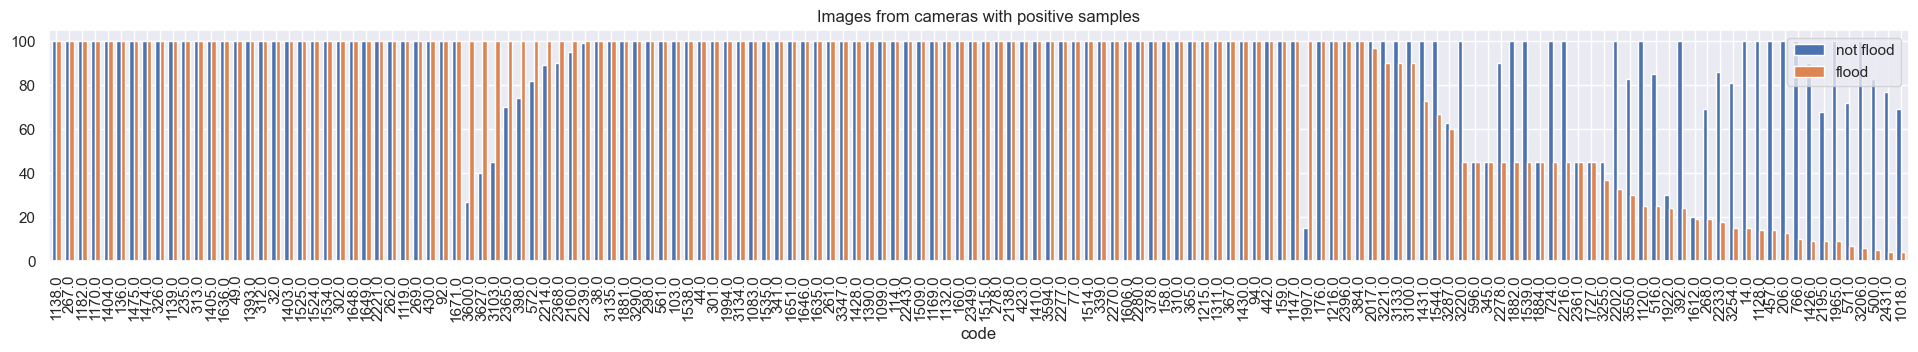

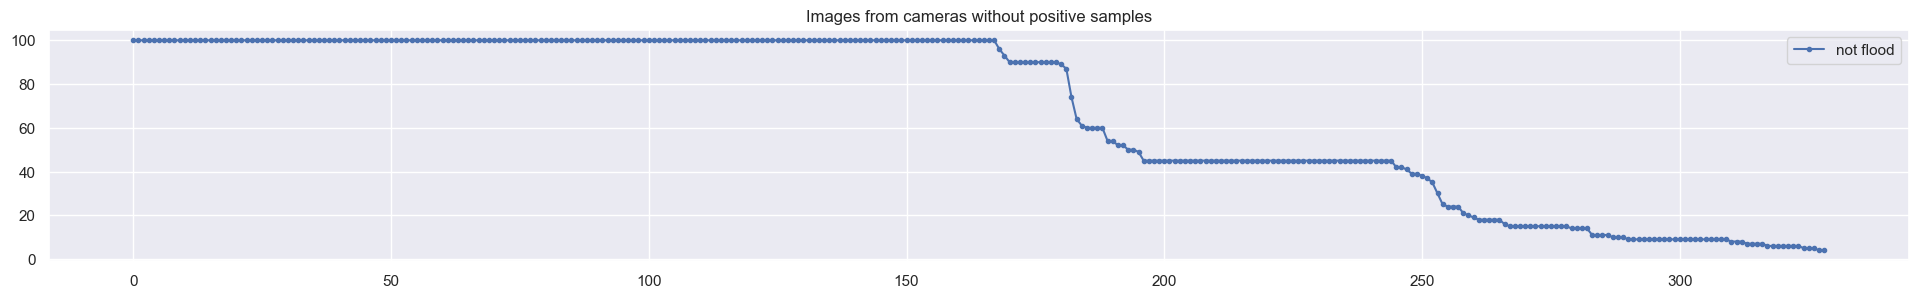

In [12]:
separate_group_class_count_plot(y_even, groups_even, figsize=(24, 3))

---
## 5. Train and Test Splits

### Balanced test and validation sets

codes,1410.0,1169.0,1170.0,1182.0,159.0,160.0,32.0,38.0,298.0,44.0,...,1509.0,2278.0,1514.0,1648.0,1649.0,1138.0,1651.0,1524.0,500.0,1403.0
Test,,,,,,,,,,,,,,,,,,,,,
class 0,100,100,100,100,100,100,100,100,100,100,...,100,90,100,100,100,100,100,100,83,100
class 1,100,100,100,100,100,100,100,100,100,100,...,100,45,100,100,100,100,100,100,5,100


codes,1538.0,3206.0,3594.0,267.0,3221.0,278.0,1431.0,2216.0,310.0,3254.0,...,1635.0,1128.0,1515.0,1132.0,365.0,1390.0,367.0,1907.0,1018.0,1535.0
Validation,,,,,,,,,,,,,,,,,,,,,
class 0,100,100,100,100,100,100,100,100,100,81,...,100,100,100,100,100,100,100,15,69,100
class 1,100,6,100,100,90,100,73,45,100,15,...,100,14,100,100,100,100,100,100,4,100


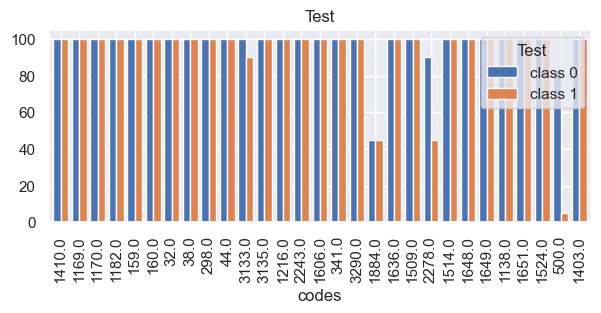

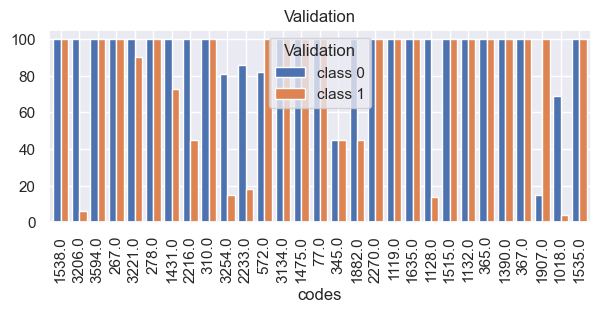

In [13]:
test_index = y_even[groups_even.isin(codes_1_test)].index
val_index = y_even[groups_even.isin(codes_1_val)].index

group_class_count_plot(y, groups, [], test_index, val_index, plot=True)

### Natural class proportion for cameras with positive samples

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,86.0,18.18,15000.0,2.53,10298.0,4702.0,2.23,3.61,68.65
test,29.0,6.13,5503.0,0.93,2818.0,2685.0,0.61,2.06,51.21
val,29.0,6.13,4933.0,0.83,2678.0,2255.0,0.58,1.73,54.29



TRAINING SET CLASS DISTRIBUTION:



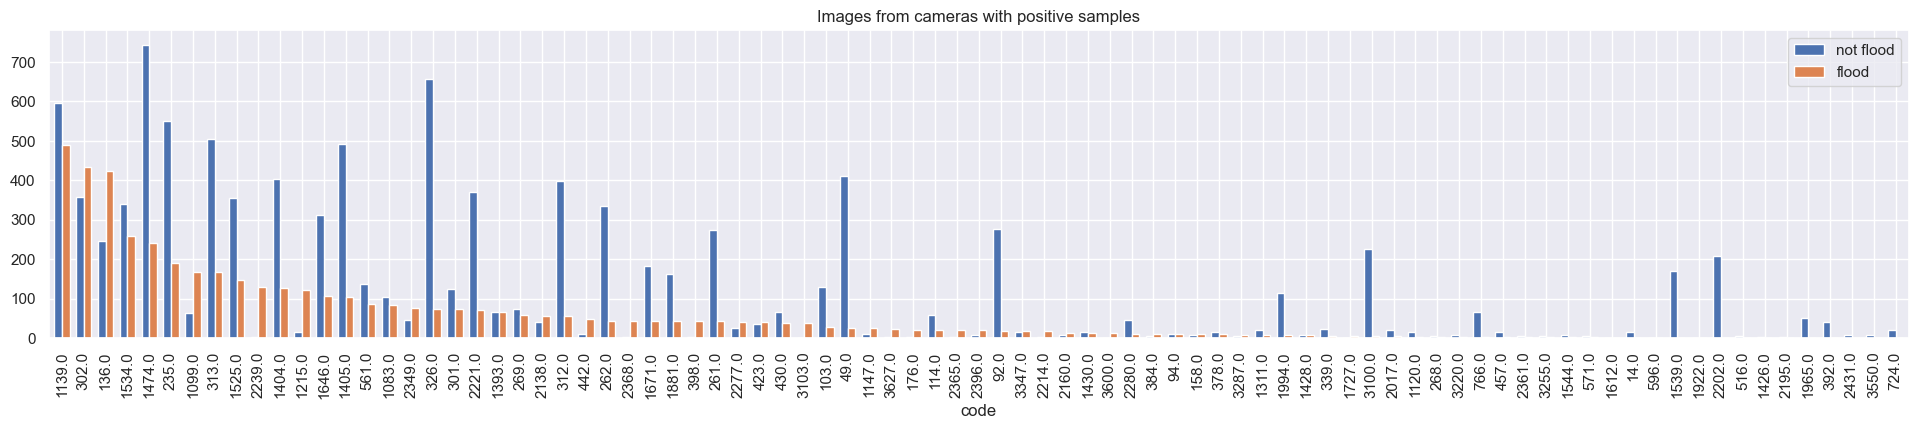

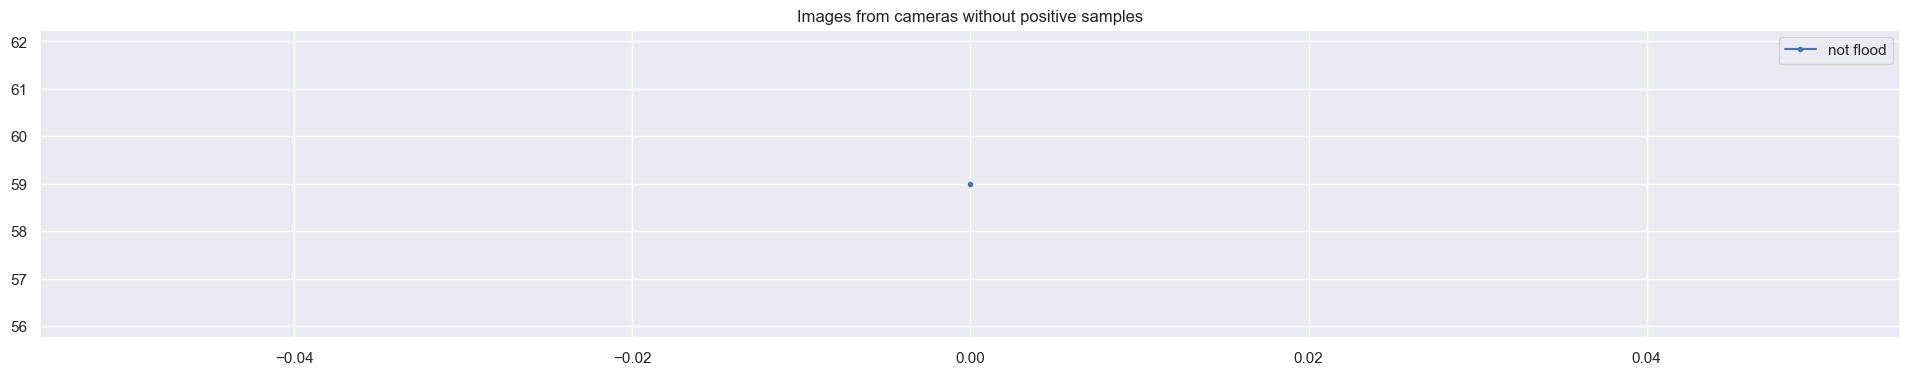

In [15]:
train_size = 15000

train_index = y[groups.isin(codes_1_train)].index.tolist()

if train_size is not None:
    train_index = sample(list(train_index), size=train_size, seed=random_state)

display(group_split_report(y, groups, train_index, test_index, val_index))
print('\nTRAINING SET CLASS DISTRIBUTION:\n')
separate_group_class_count_plot(y.loc[train_index], groups.loc[train_index], figsize=(24, 4))

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [16]:
from modules.image_dataset_util import copy_images_to_folders

target_directory = 'data/splits/natural_positive'

copy_images_to_folders(
    base_directory='data/images',
    target_directory=target_directory,
    dataset=data.copy(),
    train_index=train_index,
    test_index=test_index,
    val_index=val_index,
    file_path_field='file_path',
    tag_field='flood'
)

Copying images to train folders:
Processed 15000/15000 files (100.00%) - Found: 15000/15000
Copying images to test folders:
Processed 5503/5503 files (100.00%) - Found: 5503/5503
Copying images to val folders:


#### Save dataframe of sample images

In [17]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')

print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (25436, 13)


### Natural class proportion for all cameras

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,250.0,52.85,15000.0,2.53,11832.0,3168.0,2.56,2.43,78.88
test,29.0,6.13,5503.0,0.93,2818.0,2685.0,0.61,2.06,51.21
val,29.0,6.13,4933.0,0.83,2678.0,2255.0,0.58,1.73,54.29



TRAINING SET CLASS DISTRIBUTION:



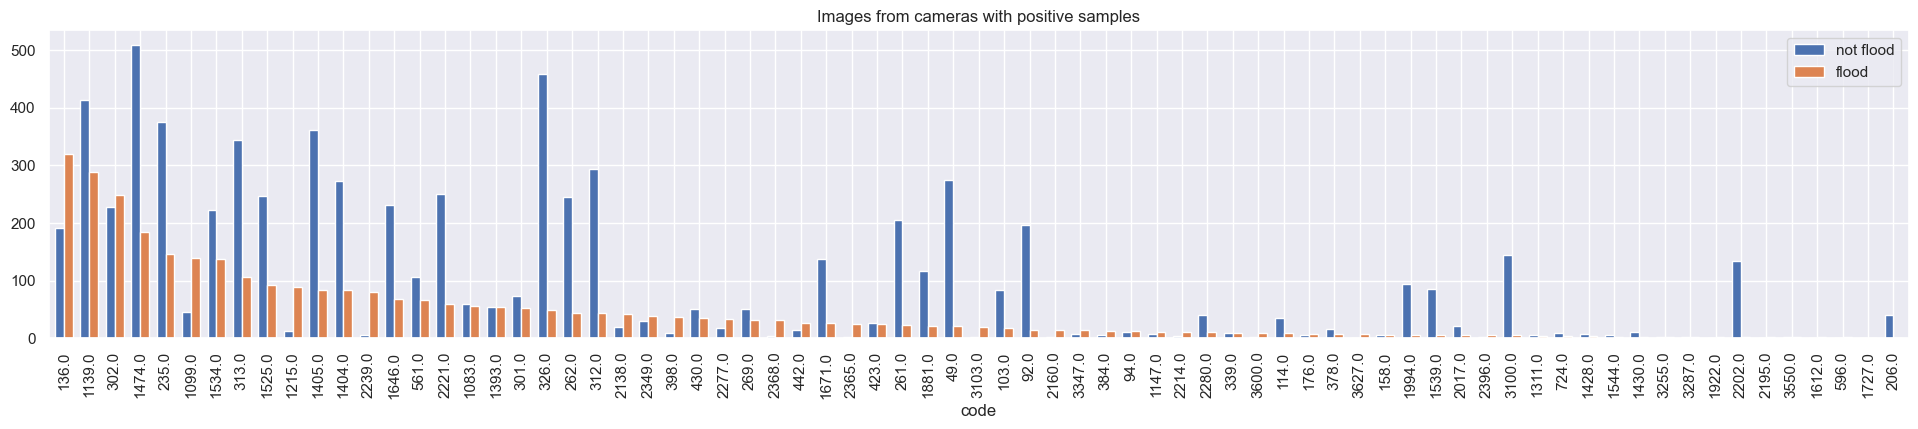

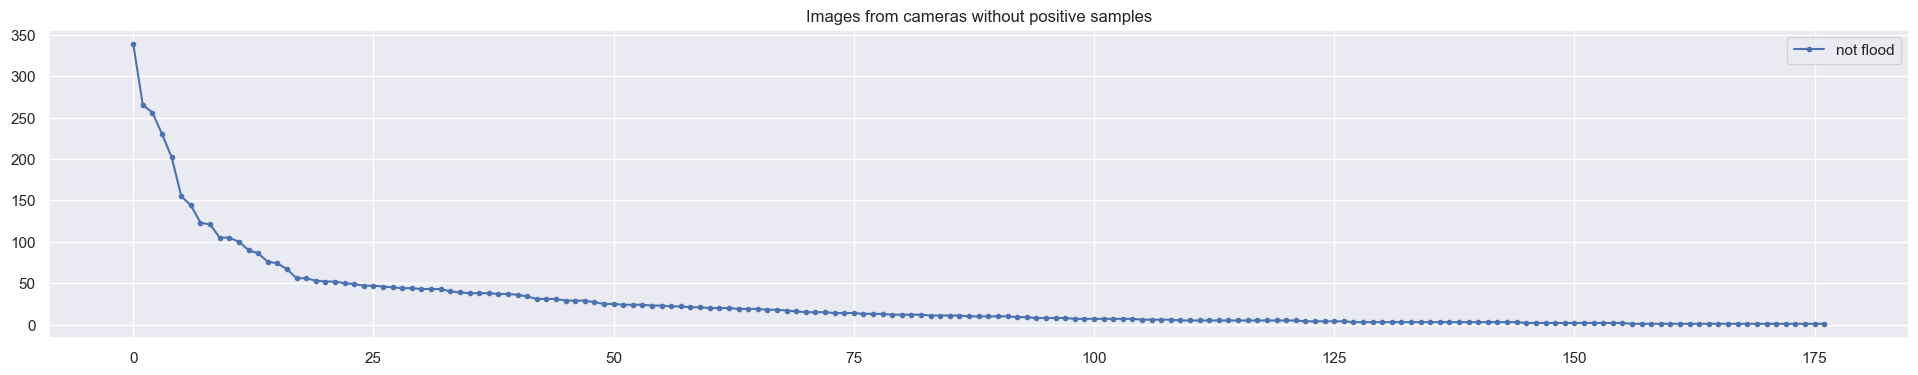

In [18]:
train_size = 15000

train_index = y[groups.isin(codes_train)].index

if train_size is not None:
    train_index = sample(list(train_index), size=train_size, seed=random_state)

display(group_split_report(y, groups, train_index, test_index, val_index))

print('\nTRAINING SET CLASS DISTRIBUTION:\n')
separate_group_class_count_plot(y.loc[train_index], groups.loc[train_index], figsize=(24, 4))

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [20]:
from modules.image_dataset_util import copy_images_to_folders

target_directory = 'data/splits/natural'

copy_images_to_folders(
    base_directory='data/images',
    target_directory=target_directory,
    dataset=data.copy(),
    train_index=train_index,
    test_index=test_index,
    val_index=val_index,
    file_path_field='file_path',
    tag_field='flood'
)

Copying images to train folders:
Processed 15000/15000 files (100.00%) - Found: 15000/15000
Copying images to test folders:
Processed 5503/5503 files (100.00%) - Found: 5503/5503
Copying images to val folders:


#### Save dataframe of sample images

In [21]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (25436, 13)


### Balanced class proportion for cameras with positive samples

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,86.0,18.18,14476.0,30.67,7766.0,6710.0,21.85,57.60,53.65
test,29.0,6.13,5503.0,11.66,2818.0,2685.0,7.93,23.05,51.21
val,29.0,6.13,4933.0,10.45,2678.0,2255.0,7.53,19.36,54.29



TRAINING SET CLASS DISTRIBUTION:



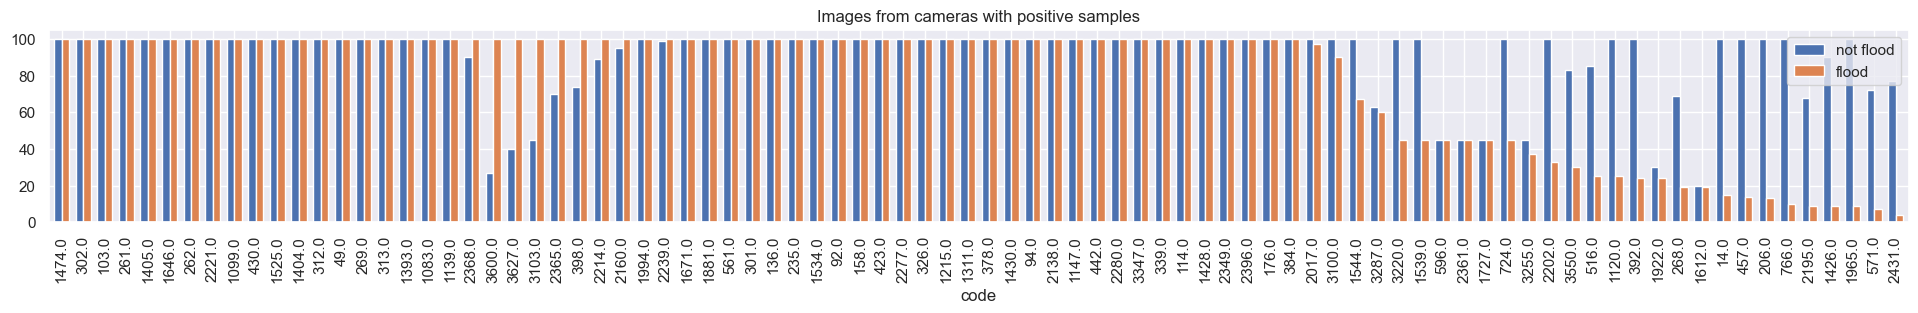

In [22]:
train_index = y_even[groups_even.isin(codes_1_train)].index

display(group_split_report(y_even, groups_even, train_index, test_index, val_index))

print('\nTRAINING SET CLASS DISTRIBUTION:\n')
separate_group_class_count_plot(y.loc[train_index], groups.loc[train_index], figsize=(24, 2.5))

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [23]:
from modules.image_dataset_util import copy_images_to_folders

target_directory = 'data/splits/balanced_positive'

copy_images_to_folders(
    base_directory='data/images',
    target_directory=target_directory,
    dataset=data.copy(),
    train_index=train_index,
    test_index=test_index,
    val_index=val_index,
    file_path_field='file_path',
    tag_field='flood'
)

Copying images to train folders:
Processed 14476/14476 files (100.00%) - Found: 14476/14476
Copying images to test folders:
Processed 5503/5503 files (100.00%) - Found: 5503/5503
Copying images to val folders:


#### Save dataframe of sample images

In [24]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (24912, 13)


### Balanced class proportion for all cameras

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,283.0,59.83,28141.0,59.63,21431.0,6710.0,60.29,57.60,76.16
test,29.0,6.13,5503.0,11.66,2818.0,2685.0,7.93,23.05,51.21
val,29.0,6.13,4933.0,10.45,2678.0,2255.0,7.53,19.36,54.29



TRAINING SET CLASS DISTRIBUTION:



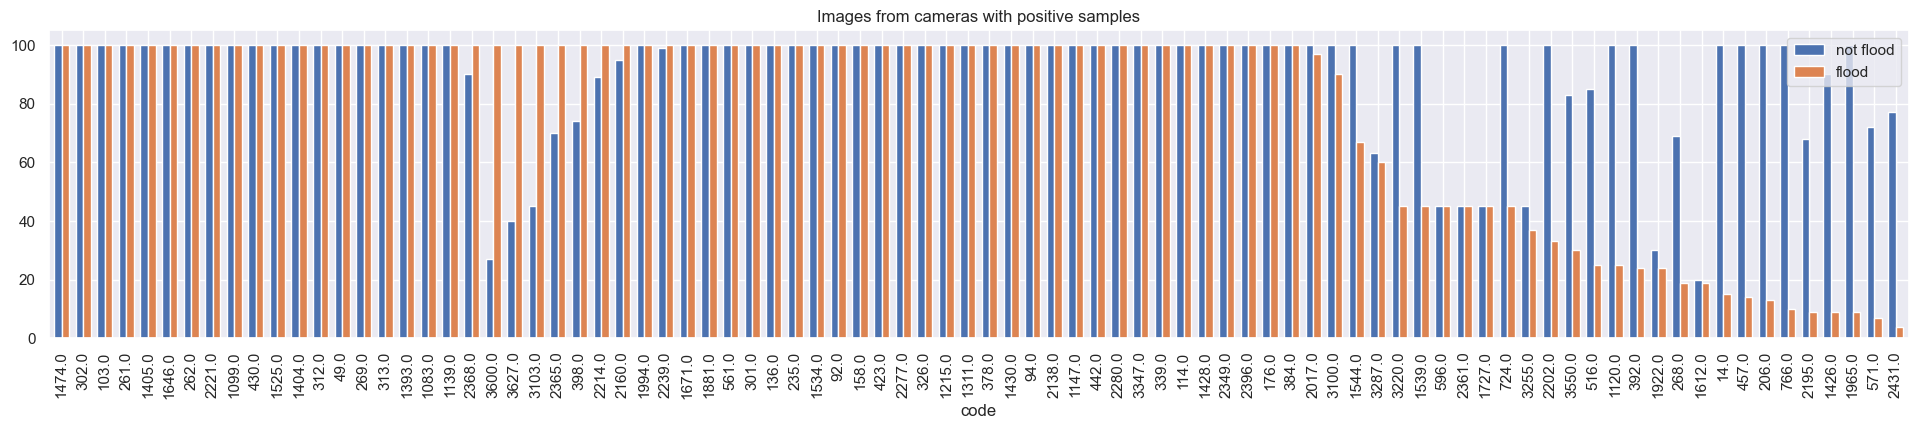

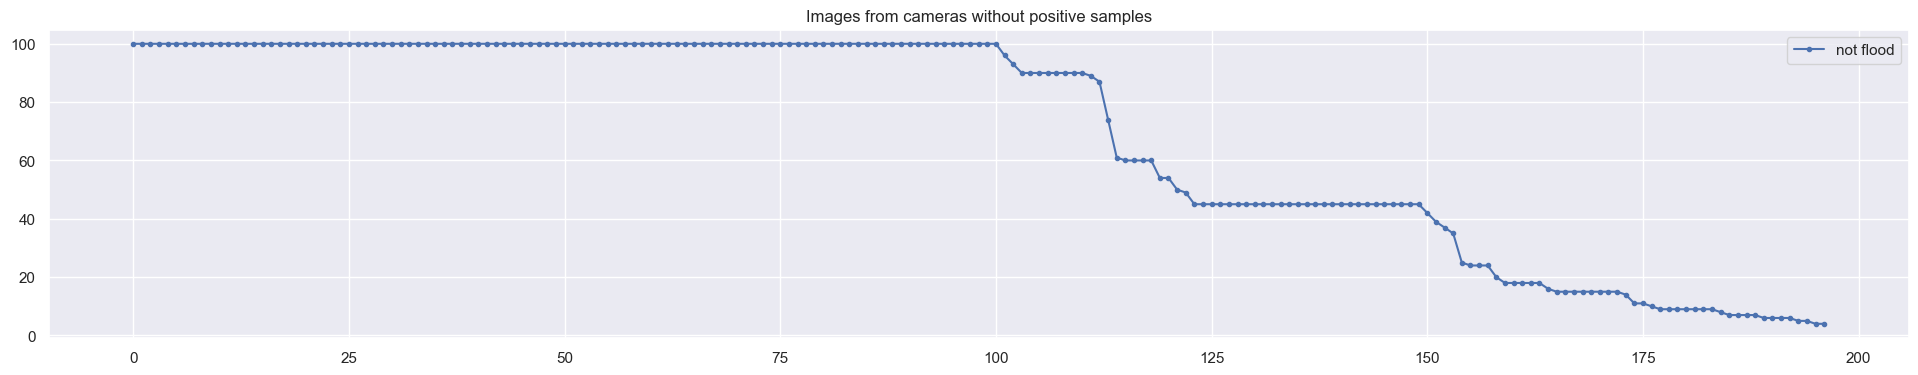

In [25]:
train_index = y_even[groups_even.isin(codes_train)].index

display(group_split_report(y_even, groups_even, train_index, test_index, val_index))

print('\nTRAINING SET CLASS DISTRIBUTION:\n')
separate_group_class_count_plot(y.loc[train_index], groups.loc[train_index], figsize=(24, 4))

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [26]:
from modules.image_dataset_util import copy_images_to_folders

target_directory = 'data/splits/balanced'

copy_images_to_folders(
    base_directory='data/images',
    target_directory=target_directory,
    dataset=data.copy(),
    train_index=train_index,
    test_index=test_index,
    val_index=val_index,
    file_path_field='file_path',
    tag_field='flood'
)

Copying images to train folders:
Processed 28141/28141 files (100.00%) - Found: 28141/28141
Copying images to test folders:
Processed 5503/5503 files (100.00%) - Found: 5503/5503
Copying images to val folders:


#### Save dataframe of sample images

In [27]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (38577, 13)


### Balanced class proportion for all cameras + Negative images from test and validation cameras

Groups intersecting train and test sets: 26
Groups intersecting train and val sets: 23
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,332.0,70.19,32849.0,5.55,26139.0,6710.0,5.66,5.15,79.57
test,29.0,6.13,5503.0,0.93,2818.0,2685.0,0.61,2.06,51.21
val,29.0,6.13,4933.0,0.83,2678.0,2255.0,0.58,1.73,54.29



TRAINING SET CLASS DISTRIBUTION:



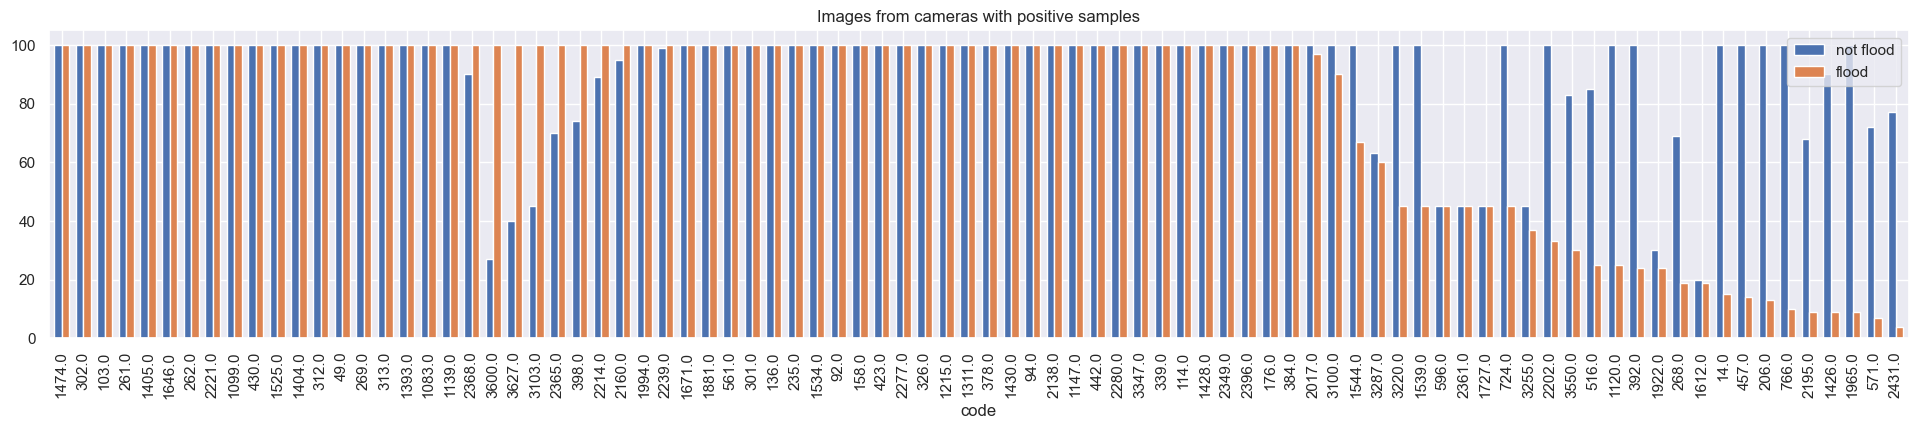

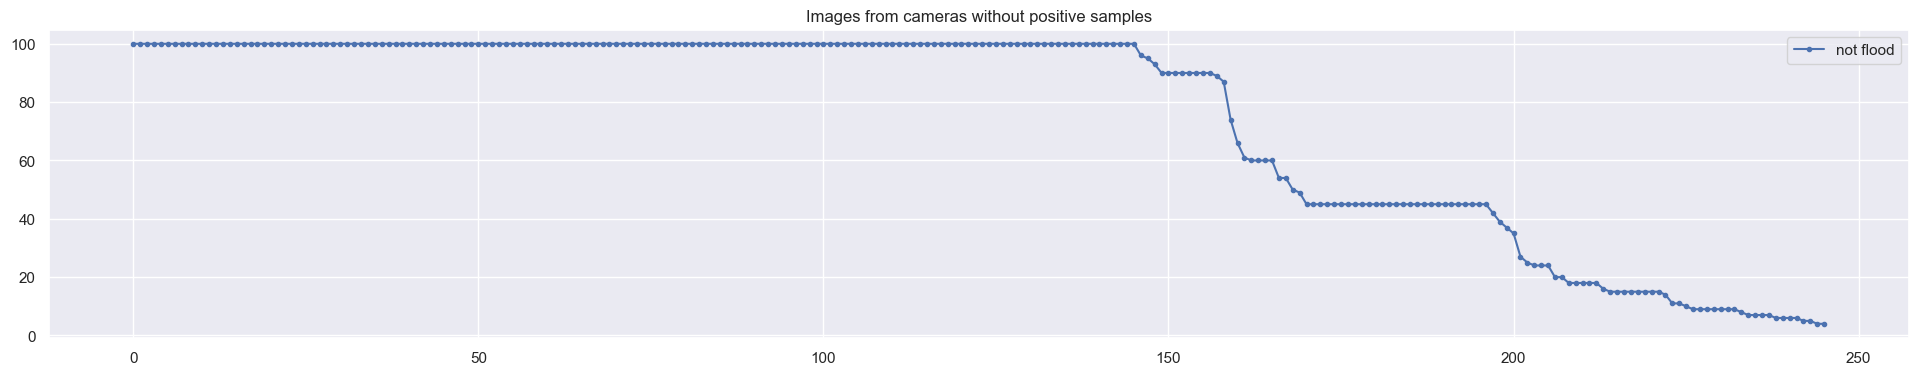

,,images from test cameras in train set
code,flood,
32.0,0,100
38.0,0,100
3135.0,0,100
3133.0,0,100
2243.0,0,100
1651.0,0,100
1649.0,0,100
1648.0,0,100
1636.0,0,100


,,images from validation cameras in train set
code,flood,
77.0,0,100
267.0,0,100
3206.0,0,100
3134.0,0,100
2270.0,0,100
2216.0,0,100
1882.0,0,100
1635.0,0,100
1538.0,0,100


In [28]:
camera_negative_samples = 100

train_index = y_even[groups_even.isin(codes_train)].index.tolist()

y_1_test = y[groups.isin(codes_1_test)]
y_1_test_left_index = list(set(y_1_test.index).difference(test_index))
y_1_test_left = y.loc[y_1_test_left_index]
y_1_test_left_negative = y_1_test_left[y_1_test_left == 0]
groups_1_test_left_negative = groups.loc[y_1_test_left_negative.index]

for code in codes_1_test:
    y_1_test_left_negative_code = y_1_test_left_negative[groups_1_test_left_negative == code]
    n_imgs = len(y_1_test_left_negative_code)
    if n_imgs:
        train_index += y_1_test_left_negative_code.sample(min(n_imgs, camera_negative_samples), replace=replace, random_state=random_state).index.tolist()

y_1_val = y[groups.isin(codes_1_val)]
y_1_val_left_index = list(set(y_1_val.index).difference(val_index))
y_1_val_left = y.loc[y_1_val_left_index]
y_1_val_left_negative = y_1_val_left[y_1_val_left == 0]
groups_1_val_left_negative = groups.loc[y_1_val_left_negative.index]

for code in codes_1_val:
    y_1_val_left_negative_code = y_1_val_left_negative[groups_1_val_left_negative == code]
    n_imgs = len(y_1_val_left_negative_code)
    if n_imgs:
        train_index += y_1_val_left_negative_code.sample(min(n_imgs, camera_negative_samples), replace=replace, random_state=random_state).index.tolist()

# ---
# Display statistics and class count per camera
display(group_split_report(y, groups, train_index, test_index, val_index))

print('\nTRAINING SET CLASS DISTRIBUTION:\n')
separate_group_class_count_plot(y.loc[train_index], groups.loc[train_index], figsize=(24, 4))

# ---
# --- Count images from test and val cameras in train set

groups_train = groups.loc[train_index]

groups_train_1_test = groups_train[groups_train.isin(codes_1_test)]
cnts_train_1_test = pd.concat([groups_train_1_test, y.loc[groups_train_1_test.index]], axis=1)

groups_train_1_val = groups_train[groups_train.isin(codes_1_val)]
cnts_train_1_val = pd.concat([groups_train_1_val, y.loc[groups_train_1_val.index]], axis=1)

display(cnts_train_1_test.value_counts().to_frame('images from test cameras in train set'))
display(cnts_train_1_val.value_counts().to_frame('images from validation cameras in train set'))

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [29]:
from modules.image_dataset_util import copy_images_to_folders

target_directory = 'data/splits/balanced_negative_test'

copy_images_to_folders(
    base_directory='data/images',
    target_directory=target_directory,
    dataset=data.copy(),
    train_index=train_index,
    test_index=test_index,
    val_index=val_index,
    file_path_field='file_path',
    tag_field='flood'
)

Copying images to train folders:
Processed 32849/32849 files (100.00%) - Found: 32849/32849
Copying images to test folders:
Processed 5503/5503 files (100.00%) - Found: 5503/5503
Copying images to val folders:


#### Save dataframe of sample images

In [30]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (43285, 13)


----

## Full training sets

### Full balanced class proportion for all cameras (train + test)

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,378.0,79.92,37674.0,79.83,28279.0,9395.0,79.56,80.64,24.94
test,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,NaN
val,29.0,6.13,4933.0,10.45,2678.0,2255.0,7.53,19.36,45.71



TRAINING SET CLASS DISTRIBUTION:



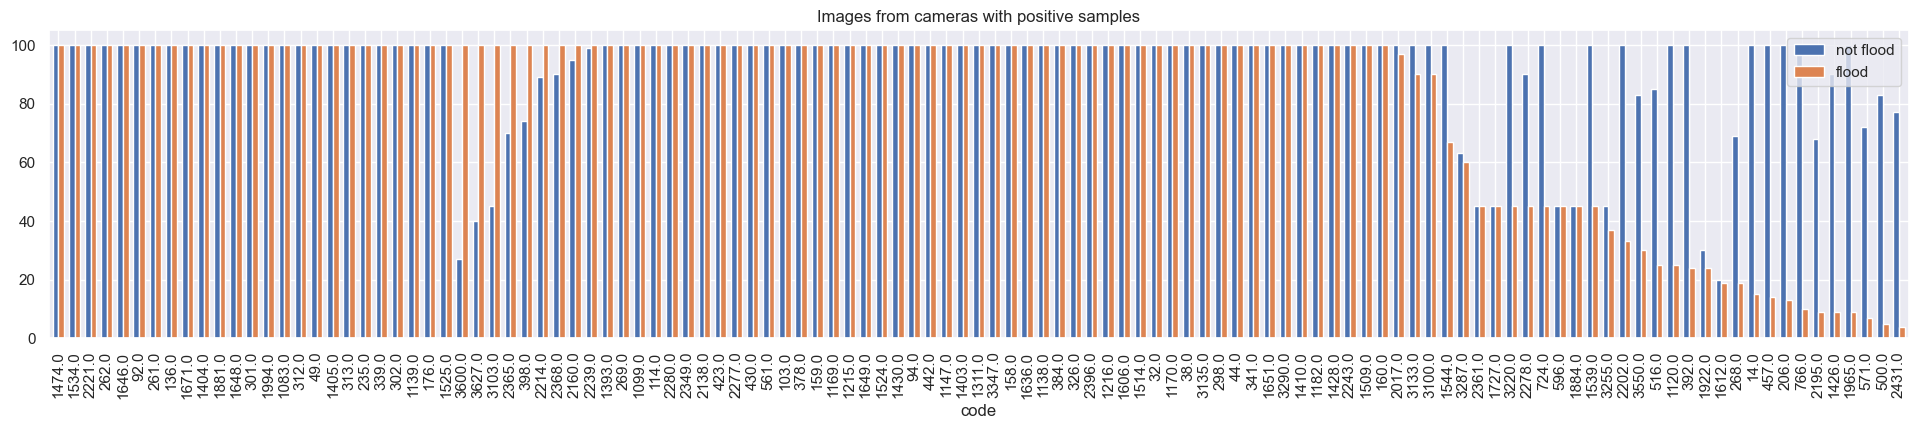

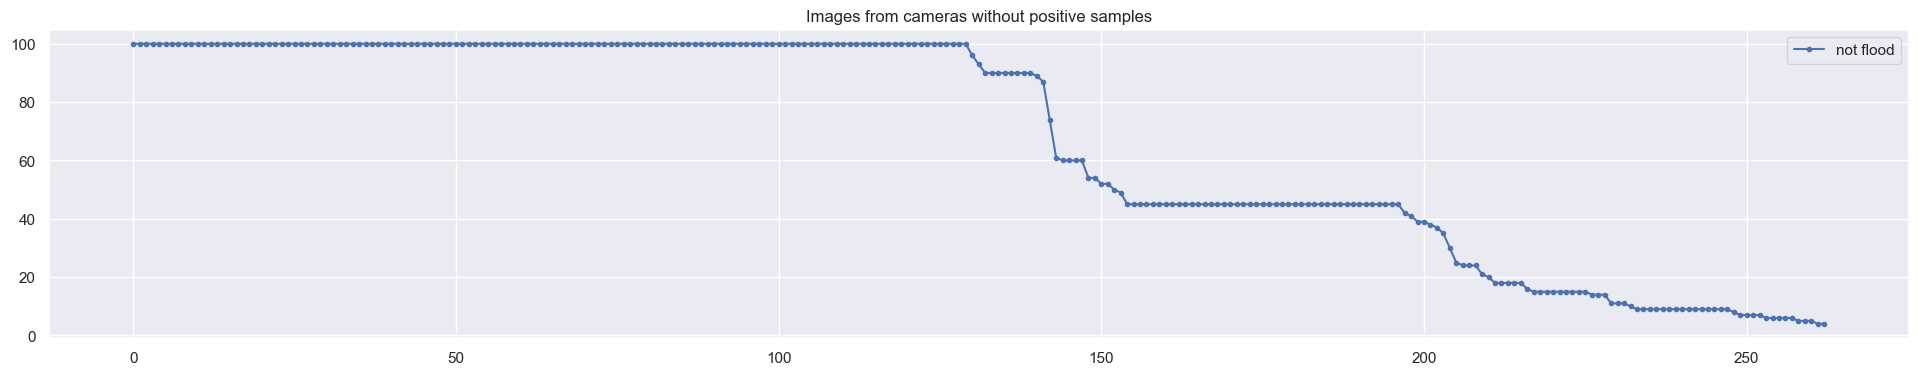

In [14]:
train_index = y_even[groups_even.isin(codes_train)].index
test_index = y_even[groups_even.isin(codes_test)].index

train_index = train_index.tolist() + test_index.tolist()
test_index = []
val_index = y_even[groups_even.isin(codes_1_val)].index

display(group_split_report(y_even, groups_even, train_index, test_index, val_index))

print('\nTRAINING SET CLASS DISTRIBUTION:\n')
separate_group_class_count_plot(y.loc[train_index], groups.loc[train_index], figsize=(24, 4))

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [16]:
from modules.image_dataset_util import copy_images_to_folders

target_directory = 'data/splits/balanced_full'

copy_images_to_folders(
    base_directory='data/images',
    target_directory=target_directory,
    dataset=data.copy(),
    train_index=train_index,
    test_index=test_index,
    val_index=val_index,
    file_path_field='file_path',
    tag_field='flood'
)

Copying images to train folders:
Processed 37674/37674 files (100.00%) - Found: 37674/37674
Copying images to val folders:


#### Save dataframe of sample images

In [17]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (42607, 13)
